<a href="https://colab.research.google.com/github/sudhakarmlal/EVA4/blob/master/Session11/models/S11_final_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Assignment S11 (Super Convergence)
In this assignment, for training CIPHAR-10 dataset, Custom ResNet architecutre, Data Augmentation (Padding, RadnomCrop, Cutout, Horizontal Flip) and One Cycle LR policy are used to train teh model in 24 epochs and achieved 91.05% Test Accuracy . Developed APIs so as to load data, train, test and show results.

Following changes are done:

1. Added Data Augmentations (Albumentatons)

i. Padding (4)

ii. RandomCrop

iii. Cutout

iv. Horizontal Flip

2. Plotted the Cyclic LR over iterations

3. Performed LR Range Test for various maximum LR values for test accuracy in 5 epochs

4. Used One Cycle learning strategey for scheduling learning rates

Got best test accuracy: 91.05%


In [0]:
%matplotlib inline
import autoreload
%load_ext autoreload
%autoreload

In [0]:
!pip install -U git+https://github.com/albu/albumentations --no-cache-dir

  Cloning https://github.com/albu/albumentations to /tmp/pip-req-build-xmqys2tq
  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-xmqys2tq
     |████████████████████████████████| 634kB 1.4MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.5-cp36-none-any.whl size=65099 sha256=fe7310d50005d60d6f28e9e88b0678ffe948d16d3ca737c0d699c9e1f7544dd1
  Stored in directory: /tmp/pip-ephem-wheel-cache-6nhp7ktr/wheels/45/8b/e4/2837bbcf517d00732b8e394f8646f22b8723ac00993230188b
  Created wheel for imgaug: filename=imgaug-0.2.6-cp36-none-any.whl size=654020 sha256=80d52fe0063eb880d4b33b92b2398965395ca784d2be0e987d70f5f9ac7f5ed8
  Stored in directory: /tmp/pip-ephem-wheel-cache-6nhp7ktr/wheels/97/ec/48/0d25896c417b715af6236dbcef8f0bed136a1a5e52972fc6d0
Successfully built albumentations imgaug
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing installation: album

## Mount the google drive

In [0]:
# Mount the google drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## Copy all the API python files from the google drive to local folder

Follwing python files are imported from google drive. Purpsoe of these files are as below:

model.py - Defines the model class Net
train_test.py- API for training and testing
accuracy_utils - API foro getting test accuracy and per class accuracy
data_loader.py - API for loading train and test data
data_transform.py - API for transforming and normalizing data
plot_metrics.py - API for plotting metrics

In [0]:
!cp -rf '/content/drive/My Drive/eva_apis/data_loaders' .
!cp -rf '/content/drive/My Drive/eva_apis/data_transformations' .
!cp -rf '/content/drive/My Drive/eva_apis/models' .
!cp -rf '/content/drive/My Drive/eva_apis/utils' .

## Import all the libraries

In [0]:
from PIL import Image
import cv2
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from data_transformations.data_transform_ciphar10_custom_resnet import get_train_transform, get_test_transform
from data_loaders.ciphar10_data_loader import get_train_loader, get_test_loader, get_classes
from models.CustomResNet import CustomResNet
from utils.train_test_utils import train,test
from utils.accuracy_utils import get_test_accuracy,get_accuracy_per_class
from utils.plot_metrics_utils import plot_loss_accuracy,plot_accuracy

from utils.misclassified_image_utils import  display_misclassfied_ciphar10_images
from utils.gradcamkz_util import GRADCAM, PLOT,PLOTGRADCAM
from utils.gradcamkz_util import process_for_grad_cam
from utils.cyclic_lr_util import triangle_lr_plot,custom_one_cycle_lr




## PLOT CYCLIC LR

In this step, cyclic LR  is plotted over iterations. In this example, minimum LR =0.01, maximum LR =0.4, Step size = 10, Number of Iterations = 100 are used

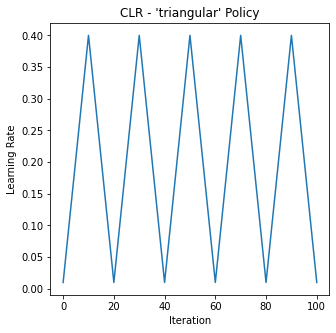

In [0]:
triangle_lr_plot(0.01, 0.4, 10, 100)


Training a Classifier
=====================



Training an image classifier
----------------------------

I have done the following steps in order:

1. Load and normalizing the CIFAR10 training and test datasets using
   ``torchvision``
2. Define a Convolution Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data





 ## 1. Loading and normalizing CIFAR10

 I have used APIs get_train_loader, get_test_loader to load train data and test data respectively. Both the APIs internally uses torchvision. I have used get_transform API to transform tensors in the range [-1,1]



In [0]:
BATCH_SIZE=512

transform_train = get_train_transform()
transform_test = get_test_transform()

trainloader = get_train_loader(BATCH_SIZE, transform_train)
testloader = get_test_loader(BATCH_SIZE, transform_test)
classes = get_classes()

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


## Visualizing some of the images in train dataset



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


  dog   cat   car   cat


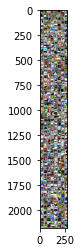

In [0]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

## 2. Define a Convolution Neural Network

I have defined the custom ResNet18 model 



In [0]:
!pip install torchsummary
from torchsummary import summary
model =  CustomResNet()
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model.device = torch.device("cuda" if use_cuda else "cpu")
model =  CustomResNet().to(model.device)
print(model)
summary(model, input_size=(3, 32, 32))

CustomResNet(
  (conv): ConvBNBlock(
    (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (drop_out): Dropout2d(p=0.0, inplace=False)
  )
  (layer1): ResBlock(
    (transition_block): TransitionBlock(
      (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_out): Dropout2d(p=0.0, inplace=False)
    )
    (conv_block1): ConvBNBlock(
      (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_out): Dropout2d(p=0.0, inplace=False)
    )
    (conv_block2): ConvBNBlock(
      (conv): Conv2d(128, 1

/content/models/CustomResNet.py:77: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)


## LR Range Test

In this step, a ranges of maximum Learning Rate values are searched for which gives good test accuracy in 5 epochs.

In [0]:
from torch.optim.lr_scheduler import LambdaLR
import torch.optim as optim
import os

model =  CustomResNet().to(device)
PATH_BASE_MODEL = 'base_weights_lr_range_test.pth'
torch.save(model.state_dict(), PATH_BASE_MODEL)

EPOCHS_TO_TRY = 5

max_lr_list = [0.001, 0.004, 0.008, 0.01,0.04,0.08,0.1,0.4,0.8,1,2,4]
test_accuracy_list = []

for lr_value in max_lr_list:
    model.load_state_dict(torch.load(PATH_BASE_MODEL))
    optimizer = optim.SGD(model.parameters(), lr=lr_value/10, momentum=0.9)

    lr_finder_schedule = lambda t: np.interp([t], [0, EPOCHS_TO_TRY], [lr_value/10,  lr_value])[0]
    lr_finder_lambda = lambda it: lr_finder_schedule(it * BATCH_SIZE/50176)
    max_lr_finder = max_lr_finder_schedule(no_of_images=50176, batch_size=BATCH_SIZE, base_lr=lr_value/10, max_lr=lr_value, total_epochs=5)
    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=[max_lr_finder])
    train_losses = []
    test_losses = []
    train_acc = []
    test_acc = []
    for epoch in range(EPOCHS_TO_TRY):
        print("MAX LR:" ,lr_value, " EPOCH:", (epoch+1))        
        train(model, device, trainloader, optimizer, epoch, train_losses,scheduler,train_acc,True )
        test(model, device, testloader, test_losses, test_acc)
    t_acc = test_acc[-1]
    test_accuracy_list.append(t_acc)
    print(" For Max LR: ", lr_value, " Test Accuracy: ", t_acc)

  0%|          | 0/98 [00:00<?, ?it/s]

MAX LR: 0.001  EPOCH: 1


/content/models/CustomResNet.py:77: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:122: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 3.5810, Accuracy: 948/10000 (9.48%)

MAX LR: 0.001  EPOCH: 2


Loss=3.4340286254882812 Batch_id=97 Accuracy=9.06: 100%|██████████| 98/98 [00:25<00:00,  3.81it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 3.5290, Accuracy: 942/10000 (9.42%)

MAX LR: 0.001  EPOCH: 3


  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 3.5139, Accuracy: 950/10000 (9.50%)

MAX LR: 0.001  EPOCH: 4


Loss=3.3775064945220947 Batch_id=97 Accuracy=8.85: 100%|██████████| 98/98 [00:25<00:00,  3.86it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 3.4427, Accuracy: 953/10000 (9.53%)

MAX LR: 0.001  EPOCH: 5


Loss=3.3845784664154053 Batch_id=97 Accuracy=8.96: 100%|██████████| 98/98 [00:25<00:00,  3.85it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 3.3932, Accuracy: 958/10000 (9.58%)

 For Max LR:  0.001  Test Accuracy:  9.58
MAX LR: 0.004  EPOCH: 1


Loss=3.3641746044158936 Batch_id=97 Accuracy=8.95: 100%|██████████| 98/98 [00:25<00:00,  3.86it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 3.3722, Accuracy: 954/10000 (9.54%)

MAX LR: 0.004  EPOCH: 2


Loss=3.0471882820129395 Batch_id=97 Accuracy=9.04: 100%|██████████| 98/98 [00:25<00:00,  3.87it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 3.0111, Accuracy: 944/10000 (9.44%)

MAX LR: 0.004  EPOCH: 3


  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 2.7089, Accuracy: 1010/10000 (10.10%)

MAX LR: 0.004  EPOCH: 4


Loss=2.5087080001831055 Batch_id=97 Accuracy=9.81: 100%|██████████| 98/98 [00:25<00:00,  3.86it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 2.5000, Accuracy: 1107/10000 (11.07%)

MAX LR: 0.004  EPOCH: 5


Loss=2.3871448040008545 Batch_id=97 Accuracy=10.89: 100%|██████████| 98/98 [00:25<00:00,  3.87it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 2.3848, Accuracy: 1276/10000 (12.76%)

 For Max LR:  0.004  Test Accuracy:  12.76
MAX LR: 0.008  EPOCH: 1


  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 2.8964, Accuracy: 956/10000 (9.56%)

MAX LR: 0.008  EPOCH: 2


Loss=2.4613795280456543 Batch_id=97 Accuracy=9.86: 100%|██████████| 98/98 [00:25<00:00,  3.86it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 2.4361, Accuracy: 1183/10000 (11.83%)

MAX LR: 0.008  EPOCH: 3


Loss=2.3223392963409424 Batch_id=97 Accuracy=12.14: 100%|██████████| 98/98 [00:25<00:00,  3.85it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 2.3048, Accuracy: 1430/10000 (14.30%)

MAX LR: 0.008  EPOCH: 4


Loss=2.305058002471924 Batch_id=97 Accuracy=14.82: 100%|██████████| 98/98 [00:25<00:00,  3.87it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 2.2435, Accuracy: 1728/10000 (17.28%)

MAX LR: 0.008  EPOCH: 5


Loss=2.2929470539093018 Batch_id=97 Accuracy=16.87: 100%|██████████| 98/98 [00:25<00:00,  3.86it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 2.1900, Accuracy: 2014/10000 (20.14%)

 For Max LR:  0.008  Test Accuracy:  20.14
MAX LR: 0.01  EPOCH: 1


Loss=2.7165169715881348 Batch_id=97 Accuracy=9.18: 100%|██████████| 98/98 [00:25<00:00,  3.86it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 2.6806, Accuracy: 996/10000 (9.96%)

MAX LR: 0.01  EPOCH: 2


Loss=2.3266756534576416 Batch_id=97 Accuracy=11.16: 100%|██████████| 98/98 [00:25<00:00,  3.88it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 2.3382, Accuracy: 1346/10000 (13.46%)

MAX LR: 0.01  EPOCH: 3


Loss=2.233858108520508 Batch_id=97 Accuracy=13.96: 100%|██████████| 98/98 [00:25<00:00,  3.86it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 2.2509, Accuracy: 1686/10000 (16.86%)

MAX LR: 0.01  EPOCH: 4


Loss=2.1761105060577393 Batch_id=97 Accuracy=16.95: 100%|██████████| 98/98 [00:25<00:00,  3.85it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 2.1841, Accuracy: 2028/10000 (20.28%)

MAX LR: 0.01  EPOCH: 5


Loss=2.1670472621917725 Batch_id=97 Accuracy=19.95: 100%|██████████| 98/98 [00:25<00:00,  3.85it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 2.1214, Accuracy: 2320/10000 (23.20%)

 For Max LR:  0.01  Test Accuracy:  23.2
MAX LR: 0.04  EPOCH: 1


Loss=2.126964569091797 Batch_id=97 Accuracy=15.03: 100%|██████████| 98/98 [00:25<00:00,  3.84it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 2.1117, Accuracy: 2378/10000 (23.78%)

MAX LR: 0.04  EPOCH: 2


Loss=1.9953733682632446 Batch_id=97 Accuracy=25.21: 100%|██████████| 98/98 [00:25<00:00,  3.86it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 1.8907, Accuracy: 3237/10000 (32.37%)

MAX LR: 0.04  EPOCH: 3


Loss=1.8181703090667725 Batch_id=97 Accuracy=31.68: 100%|██████████| 98/98 [00:25<00:00,  3.85it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 1.7334, Accuracy: 3802/10000 (38.02%)

MAX LR: 0.04  EPOCH: 4


Loss=1.6443047523498535 Batch_id=97 Accuracy=36.65: 100%|██████████| 98/98 [00:25<00:00,  3.84it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 1.6033, Accuracy: 4250/10000 (42.50%)

MAX LR: 0.04  EPOCH: 5


Loss=1.610939383506775 Batch_id=97 Accuracy=40.41: 100%|██████████| 98/98 [00:25<00:00,  3.86it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 1.5099, Accuracy: 4522/10000 (45.22%)

 For Max LR:  0.04  Test Accuracy:  45.22
MAX LR: 0.08  EPOCH: 1


Loss=1.9058120250701904 Batch_id=97 Accuracy=21.26: 100%|██████████| 98/98 [00:25<00:00,  3.85it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 1.8341, Accuracy: 3397/10000 (33.97%)

MAX LR: 0.08  EPOCH: 2


Loss=1.6544407606124878 Batch_id=97 Accuracy=35.72: 100%|██████████| 98/98 [00:25<00:00,  3.85it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 1.5794, Accuracy: 4341/10000 (43.41%)

MAX LR: 0.08  EPOCH: 3


Loss=1.526202917098999 Batch_id=97 Accuracy=43.02: 100%|██████████| 98/98 [00:25<00:00,  3.86it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 1.4222, Accuracy: 4949/10000 (49.49%)

MAX LR: 0.08  EPOCH: 4


Loss=1.3080079555511475 Batch_id=97 Accuracy=48.48: 100%|██████████| 98/98 [00:25<00:00,  3.86it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 1.2875, Accuracy: 5385/10000 (53.85%)

MAX LR: 0.08  EPOCH: 5


  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 1.2087, Accuracy: 5637/10000 (56.37%)

 For Max LR:  0.08  Test Accuracy:  56.37
MAX LR: 0.1  EPOCH: 1


Loss=1.8822426795959473 Batch_id=97 Accuracy=23.77: 100%|██████████| 98/98 [00:25<00:00,  3.86it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 1.7437, Accuracy: 3719/10000 (37.19%)

MAX LR: 0.1  EPOCH: 2


Loss=1.565521240234375 Batch_id=97 Accuracy=38.95: 100%|██████████| 98/98 [00:25<00:00,  3.86it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 1.4633, Accuracy: 4723/10000 (47.23%)

MAX LR: 0.1  EPOCH: 3


Loss=1.3138370513916016 Batch_id=97 Accuracy=46.60: 100%|██████████| 98/98 [00:25<00:00,  3.86it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 1.3358, Accuracy: 5250/10000 (52.50%)

MAX LR: 0.1  EPOCH: 4


Loss=1.2791430950164795 Batch_id=97 Accuracy=52.69: 100%|██████████| 98/98 [00:25<00:00,  3.88it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 1.2595, Accuracy: 5452/10000 (54.52%)

MAX LR: 0.1  EPOCH: 5


Loss=1.1463062763214111 Batch_id=97 Accuracy=57.50: 100%|██████████| 98/98 [00:25<00:00,  3.87it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 1.0998, Accuracy: 6083/10000 (60.83%)

 For Max LR:  0.1  Test Accuracy:  60.83
MAX LR: 0.4  EPOCH: 1


Loss=1.4644542932510376 Batch_id=97 Accuracy=37.43: 100%|██████████| 98/98 [00:25<00:00,  3.86it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 1.2783, Accuracy: 5396/10000 (53.96%)

MAX LR: 0.4  EPOCH: 2


Loss=1.0282773971557617 Batch_id=97 Accuracy=56.86: 100%|██████████| 98/98 [00:25<00:00,  3.83it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 1.1298, Accuracy: 6098/10000 (60.98%)

MAX LR: 0.4  EPOCH: 3


Loss=1.0025418996810913 Batch_id=97 Accuracy=64.45: 100%|██████████| 98/98 [00:25<00:00,  3.84it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 1.2083, Accuracy: 6147/10000 (61.47%)

MAX LR: 0.4  EPOCH: 4


Loss=0.7449482679367065 Batch_id=97 Accuracy=69.48: 100%|██████████| 98/98 [00:25<00:00,  3.86it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 1.4841, Accuracy: 5785/10000 (57.85%)

MAX LR: 0.4  EPOCH: 5


Loss=0.720160722732544 Batch_id=97 Accuracy=73.60: 100%|██████████| 98/98 [00:25<00:00,  3.85it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.6554, Accuracy: 7845/10000 (78.45%)

 For Max LR:  0.4  Test Accuracy:  78.45
MAX LR: 0.8  EPOCH: 1


Loss=1.9668911695480347 Batch_id=97 Accuracy=34.65: 100%|██████████| 98/98 [00:25<00:00,  3.87it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 1.7871, Accuracy: 4226/10000 (42.26%)

MAX LR: 0.8  EPOCH: 2


Loss=1.1155885457992554 Batch_id=97 Accuracy=51.73: 100%|██████████| 98/98 [00:25<00:00,  3.88it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 1.5657, Accuracy: 5195/10000 (51.95%)

MAX LR: 0.8  EPOCH: 3


Loss=1.2482494115829468 Batch_id=97 Accuracy=61.84: 100%|██████████| 98/98 [00:25<00:00,  3.84it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 1.5758, Accuracy: 5621/10000 (56.21%)

MAX LR: 0.8  EPOCH: 4


Loss=0.8808292150497437 Batch_id=97 Accuracy=65.30: 100%|██████████| 98/98 [00:25<00:00,  3.84it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 1.0337, Accuracy: 6685/10000 (66.85%)

MAX LR: 0.8  EPOCH: 5


Loss=0.979963481426239 Batch_id=97 Accuracy=71.33: 100%|██████████| 98/98 [00:25<00:00,  3.86it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.7504, Accuracy: 7541/10000 (75.41%)

 For Max LR:  0.8  Test Accuracy:  75.41
MAX LR: 1  EPOCH: 1


Loss=1.8967045545578003 Batch_id=97 Accuracy=21.90: 100%|██████████| 98/98 [00:25<00:00,  3.84it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 2.1247, Accuracy: 3252/10000 (32.52%)

MAX LR: 1  EPOCH: 2


Loss=1.6946040391921997 Batch_id=97 Accuracy=36.67: 100%|██████████| 98/98 [00:25<00:00,  3.86it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 2.4413, Accuracy: 3259/10000 (32.59%)

MAX LR: 1  EPOCH: 3


Loss=1.8066635131835938 Batch_id=97 Accuracy=42.77: 100%|██████████| 98/98 [00:25<00:00,  3.86it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 2.2079, Accuracy: 4307/10000 (43.07%)

MAX LR: 1  EPOCH: 4


Loss=1.7679539918899536 Batch_id=97 Accuracy=37.19: 100%|██████████| 98/98 [00:25<00:00,  3.86it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 1.9173, Accuracy: 3463/10000 (34.63%)

MAX LR: 1  EPOCH: 5


Loss=1.513566255569458 Batch_id=97 Accuracy=48.48: 100%|██████████| 98/98 [00:25<00:00,  3.88it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 1.3131, Accuracy: 5517/10000 (55.17%)

 For Max LR:  1  Test Accuracy:  55.17
MAX LR: 2  EPOCH: 1


Loss=2.282128095626831 Batch_id=97 Accuracy=12.82: 100%|██████████| 98/98 [00:25<00:00,  3.89it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 2.2312, Accuracy: 2118/10000 (21.18%)

MAX LR: 2  EPOCH: 2


Loss=2.0129544734954834 Batch_id=97 Accuracy=23.99: 100%|██████████| 98/98 [00:25<00:00,  3.87it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 2.1436, Accuracy: 2581/10000 (25.81%)

MAX LR: 2  EPOCH: 3


Loss=1.7074213027954102 Batch_id=97 Accuracy=32.02: 100%|██████████| 98/98 [00:25<00:00,  3.87it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 1.7159, Accuracy: 3761/10000 (37.61%)

MAX LR: 2  EPOCH: 4


Loss=1.5458248853683472 Batch_id=97 Accuracy=39.57: 100%|██████████| 98/98 [00:25<00:00,  3.84it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 1.6083, Accuracy: 4185/10000 (41.85%)

MAX LR: 2  EPOCH: 5


Loss=1.3062164783477783 Batch_id=97 Accuracy=45.28: 100%|██████████| 98/98 [00:25<00:00,  3.82it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 1.6116, Accuracy: 4302/10000 (43.02%)

 For Max LR:  2  Test Accuracy:  43.02
MAX LR: 4  EPOCH: 1


Loss=2.2741894721984863 Batch_id=97 Accuracy=10.64: 100%|██████████| 98/98 [00:25<00:00,  3.89it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 2.3059, Accuracy: 1301/10000 (13.01%)

MAX LR: 4  EPOCH: 2


Loss=2.144379138946533 Batch_id=97 Accuracy=14.84: 100%|██████████| 98/98 [00:24<00:00,  3.95it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 2.1563, Accuracy: 1712/10000 (17.12%)

MAX LR: 4  EPOCH: 3


Loss=2.0745859146118164 Batch_id=97 Accuracy=17.78: 100%|██████████| 98/98 [00:24<00:00,  4.02it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 2.0515, Accuracy: 1730/10000 (17.30%)

MAX LR: 4  EPOCH: 4


Loss=2.0670177936553955 Batch_id=97 Accuracy=17.39: 100%|██████████| 98/98 [00:24<00:00,  4.05it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 2.1249, Accuracy: 1599/10000 (15.99%)

MAX LR: 4  EPOCH: 5


Loss=2.351266860961914 Batch_id=97 Accuracy=19.76: 100%|██████████| 98/98 [00:24<00:00,  4.02it/s]



Test set: Average loss: 2.7588, Accuracy: 1930/10000 (19.30%)

 For Max LR:  4  Test Accuracy:  19.3


## Plot Maximum Learning Rate vs Test Accuracy (5 epochs)

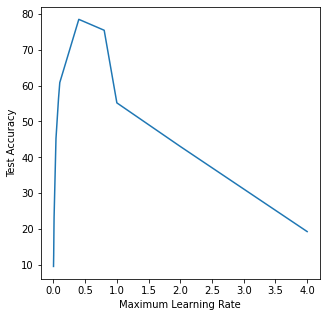

In [0]:
plot_max_lr_vs_test_accuracy(max_lr_list,test_accuracy_list)

From the LR Range Test found that maximum LR value of 0.4 gives Test Accuracy of 78.45 but maximum LR value of 0.8 gives Test accuracy of 75.41 in 5 epochs. 

However maximum LR vlaue of 0.8, there is a steady increase of test accuracy over epochs compared to maximum LR value of 0.4 ,where there is a sudden increase. So decided to use maximum LR value of 0.8

## 3. Define a Loss function and optimizer and train the model

Used Classification Cross-Entropy loss and SGD with momentum 0.9.

## 4. Train the model

 24 epochs are used to train the model. Used One Cycle LR policy for changing Learning Rates with maximum learning rate of 0.8. 

In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

In [0]:
from torch.optim.lr_scheduler import LambdaLR
import torch.optim as optim
import os

model =  CustomResNet().to(device)

optimizer = optim.SGD(model.parameters(), lr=0.04, momentum=0.9)

EPOCHS = 24

one_cyle_lr = custom_one_cycle_lr(no_of_images=50176, batch_size=BATCH_SIZE, base_lr=0.08, max_lr=0.8, final_lr=0.008, epoch_stage1=5, epoch_stage2=18, total_epochs=24)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=[one_cyle_lr])

PATH = '/content/drive/My Drive/cifar10_resnet18_one_cyclic_lr_final_2.pth'
torch.save(model.state_dict(), PATH)
best_test_accuracy = 0.0
for epoch in range(EPOCHS):
    print("EPOCH:", (epoch+1))
    train(model, device, trainloader, optimizer, epoch, train_losses,scheduler,train_acc, True )
    test(model, device, testloader, test_losses, test_acc)
    t_acc = test_acc[-1]
    if t_acc > best_test_accuracy:
        print("Test Accuracy: " + str(t_acc) + " has increased. Saving the model")
        best_test_accuracy = t_acc
        torch.save(model.state_dict(), PATH)


  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH: 1


/content/models/CustomResNet.py:77: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:122: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
Loss=1.3158868551254272 Batch_id=97 Accuracy=40.32: 100%|██████████| 98/98 [01:39<00:00,  1.02s/it]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 1.4000, Accuracy: 5455/10000 (54.55%)

Test Accuracy: 54.55 has increased. Saving the model
EPOCH: 2


Loss=0.985808789730072 Batch_id=97 Accuracy=56.92: 100%|██████████| 98/98 [01:39<00:00,  1.01s/it]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 1.0920, Accuracy: 6232/10000 (62.32%)

Test Accuracy: 62.32 has increased. Saving the model
EPOCH: 3


Loss=1.187458872795105 Batch_id=97 Accuracy=66.13: 100%|██████████| 98/98 [01:39<00:00,  1.02s/it]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 1.7496, Accuracy: 5917/10000 (59.17%)

EPOCH: 4


Loss=1.0295690298080444 Batch_id=97 Accuracy=69.68: 100%|██████████| 98/98 [01:39<00:00,  1.01s/it]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 1.0893, Accuracy: 6820/10000 (68.20%)

Test Accuracy: 68.2 has increased. Saving the model
EPOCH: 5


Loss=0.6749715209007263 Batch_id=97 Accuracy=74.11: 100%|██████████| 98/98 [01:38<00:00,  1.01s/it]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.7453, Accuracy: 7531/10000 (75.31%)

Test Accuracy: 75.31 has increased. Saving the model
EPOCH: 6


Loss=0.6637411713600159 Batch_id=97 Accuracy=76.27: 100%|██████████| 98/98 [01:38<00:00,  1.01s/it]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.8636, Accuracy: 7511/10000 (75.11%)

EPOCH: 7


Loss=0.5989397764205933 Batch_id=97 Accuracy=81.58: 100%|██████████| 98/98 [01:38<00:00,  1.01s/it]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.6287, Accuracy: 8044/10000 (80.44%)

Test Accuracy: 80.44 has increased. Saving the model
EPOCH: 8


Loss=0.4172368347644806 Batch_id=97 Accuracy=83.72: 100%|██████████| 98/98 [01:38<00:00,  1.01s/it]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.6174, Accuracy: 8014/10000 (80.14%)

EPOCH: 9


Loss=0.46466636657714844 Batch_id=97 Accuracy=85.95: 100%|██████████| 98/98 [01:38<00:00,  1.01s/it]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.5447, Accuracy: 8400/10000 (84.00%)

Test Accuracy: 84.0 has increased. Saving the model
EPOCH: 10


Loss=0.3375796973705292 Batch_id=97 Accuracy=86.99: 100%|██████████| 98/98 [01:38<00:00,  1.01s/it]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.4644, Accuracy: 8538/10000 (85.38%)

Test Accuracy: 85.38 has increased. Saving the model
EPOCH: 11


Loss=0.2578215003013611 Batch_id=97 Accuracy=88.97: 100%|██████████| 98/98 [01:38<00:00,  1.01s/it]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.4134, Accuracy: 8687/10000 (86.87%)

Test Accuracy: 86.87 has increased. Saving the model
EPOCH: 12


Loss=0.34829118847846985 Batch_id=97 Accuracy=90.12: 100%|██████████| 98/98 [01:38<00:00,  1.01s/it]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.4614, Accuracy: 8658/10000 (86.58%)

EPOCH: 13


Loss=0.219451904296875 Batch_id=97 Accuracy=90.78: 100%|██████████| 98/98 [01:38<00:00,  1.01s/it]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.3679, Accuracy: 8852/10000 (88.52%)

Test Accuracy: 88.52 has increased. Saving the model
EPOCH: 14


Loss=0.25894445180892944 Batch_id=97 Accuracy=92.35: 100%|██████████| 98/98 [01:39<00:00,  1.02s/it]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.3522, Accuracy: 8918/10000 (89.18%)

Test Accuracy: 89.18 has increased. Saving the model
EPOCH: 15


Loss=0.23112605512142181 Batch_id=97 Accuracy=93.17: 100%|██████████| 98/98 [01:39<00:00,  1.02s/it]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.3666, Accuracy: 8882/10000 (88.82%)

EPOCH: 16


Loss=0.17997615039348602 Batch_id=97 Accuracy=93.87: 100%|██████████| 98/98 [01:39<00:00,  1.02s/it]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.3526, Accuracy: 8908/10000 (89.08%)

EPOCH: 17


Loss=0.16690823435783386 Batch_id=97 Accuracy=94.38: 100%|██████████| 98/98 [01:39<00:00,  1.02s/it]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.3185, Accuracy: 9040/10000 (90.40%)

Test Accuracy: 90.4 has increased. Saving the model
EPOCH: 18


Loss=0.13394024968147278 Batch_id=97 Accuracy=95.28: 100%|██████████| 98/98 [01:39<00:00,  1.01s/it]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.3053, Accuracy: 9057/10000 (90.57%)

Test Accuracy: 90.57 has increased. Saving the model
EPOCH: 19


Loss=0.1790371686220169 Batch_id=97 Accuracy=95.45: 100%|██████████| 98/98 [01:39<00:00,  1.01s/it]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.3057, Accuracy: 9059/10000 (90.59%)

Test Accuracy: 90.59 has increased. Saving the model
EPOCH: 20


Loss=0.12321416288614273 Batch_id=97 Accuracy=95.63: 100%|██████████| 98/98 [01:39<00:00,  1.01s/it]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.3055, Accuracy: 9057/10000 (90.57%)

EPOCH: 21


Loss=0.09736372530460358 Batch_id=97 Accuracy=95.80: 100%|██████████| 98/98 [01:38<00:00,  1.01s/it]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.3034, Accuracy: 9084/10000 (90.84%)

Test Accuracy: 90.84 has increased. Saving the model
EPOCH: 22


Loss=0.09842408448457718 Batch_id=97 Accuracy=95.91: 100%|██████████| 98/98 [01:39<00:00,  1.01s/it]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.3012, Accuracy: 9093/10000 (90.93%)

Test Accuracy: 90.93 has increased. Saving the model
EPOCH: 23


Loss=0.11666856706142426 Batch_id=97 Accuracy=96.17: 100%|██████████| 98/98 [01:38<00:00,  1.01s/it]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.2990, Accuracy: 9105/10000 (91.05%)

Test Accuracy: 91.05 has increased. Saving the model
EPOCH: 24


Loss=0.14368516206741333 Batch_id=97 Accuracy=96.25: 100%|██████████| 98/98 [01:39<00:00,  1.01s/it]



Test set: Average loss: 0.2989, Accuracy: 9091/10000 (90.91%)



## Load the Best Model

In [0]:
model.load_state_dict(torch.load(PATH))
model.device = torch.device("cuda" if use_cuda else "cpu")


## 5. Test the network on the test data 


In this step
- A few actual images are shown with label.
- Next print the test accuracy using API get_test_accuracy
- Next diplay class level accuracy using API get_accuracy_per_class which will give idea about which all classes prediction was good and which all classes prediction was not that good



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


GroundTruth:    cat  ship  ship plane


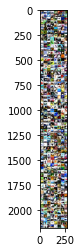

In [0]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

Okay, now let us see what the neural network thinks these examples above are:



In [0]:
with torch.no_grad():
    images, labels = images.to(device), labels.to(device)
    outputs = model(images) 

/content/models/CustomResNet.py:77: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)


The outputs are energies for the 10 classes.
Higher the energy for a class, the more the network
thinks that the image is of the particular class.
So, let's get the index of the highest energy:



In [0]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat  ship  ship plane


The results seem pretty good.

Let us look at how the network performs on the whole dataset.



In [0]:
print('Accuracy of the network on the 10000 test images: %.2f %%' % (
    get_test_accuracy(model, testloader, device)))

/content/models/CustomResNet.py:77: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)


Accuracy of the network on the 10000 test images: 91.05 %




The accuracy 89.98 is far better than chance, which is 10% accuracy (randomly picking a class out of 10 classes).
Seems like the network learnt good.

Hmmm, what are the classes that performed well, and the classes that did
not perform well:



In [0]:
class_correct,class_total = get_accuracy_per_class(model, testloader, device)

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

/content/models/CustomResNet.py:77: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)


Accuracy of plane : 85 %
Accuracy of   car : 100 %
Accuracy of  bird : 85 %
Accuracy of   cat : 75 %
Accuracy of  deer : 100 %
Accuracy of   dog : 66 %
Accuracy of  frog : 81 %
Accuracy of horse : 83 %
Accuracy of  ship : 91 %
Accuracy of truck : 100 %


## Plot the performance metrics

In this step, the following metrics are plotted

i. Training Accuracy
ii. Test Accuracy

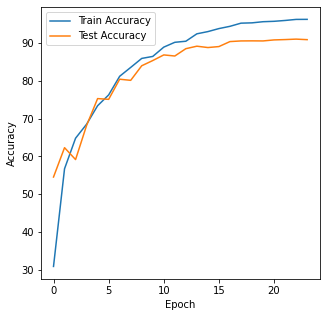

In [0]:
plot_accuracy(train_acc, test_acc)


## Display Misclassified Images

/content/models/CustomResNet.py:77: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range fo

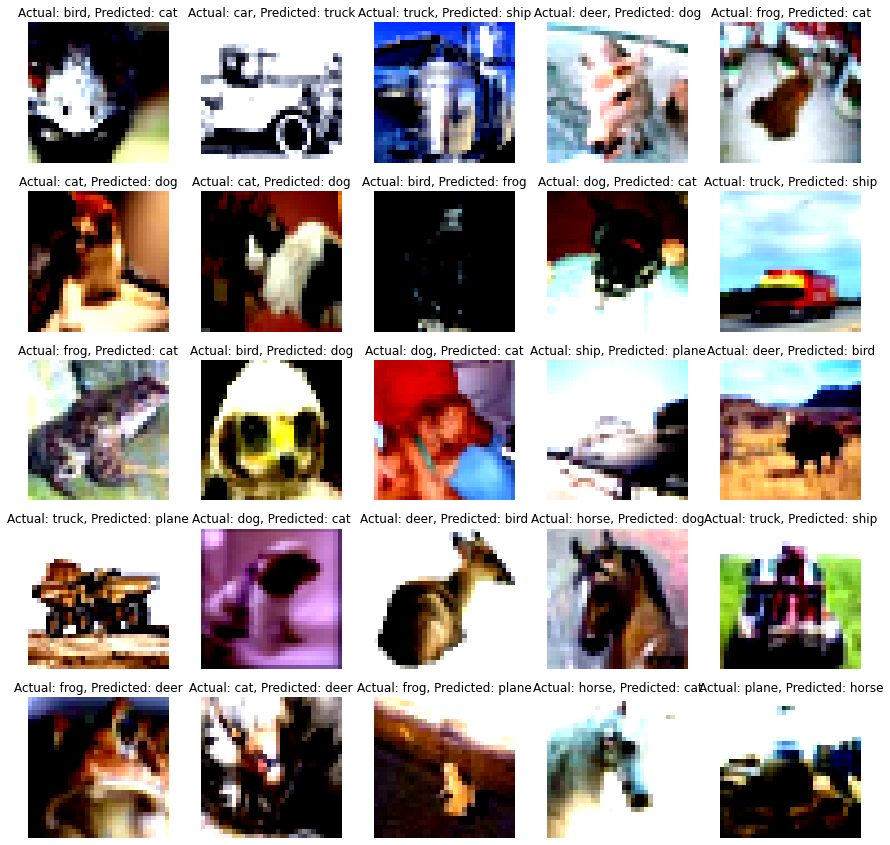

In [0]:
incorrect_images_list,predicted_label_list,correct_label_list=display_misclassfied_ciphar10_images(testloader, model, device, classes, 25)

In [0]:
incorrect_images=process_for_grad_cam(incorrect_images_list,predicted_label_list,correct_label_list,transform_test)

##Display GRADCAM for Misclassified Images

/content/models/CustomResNet.py:77: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([25, 10])
Generating Grad-CAM @layer1
Generating Grad-CAM @layer2
Generating Grad-CAM @layer3
25


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


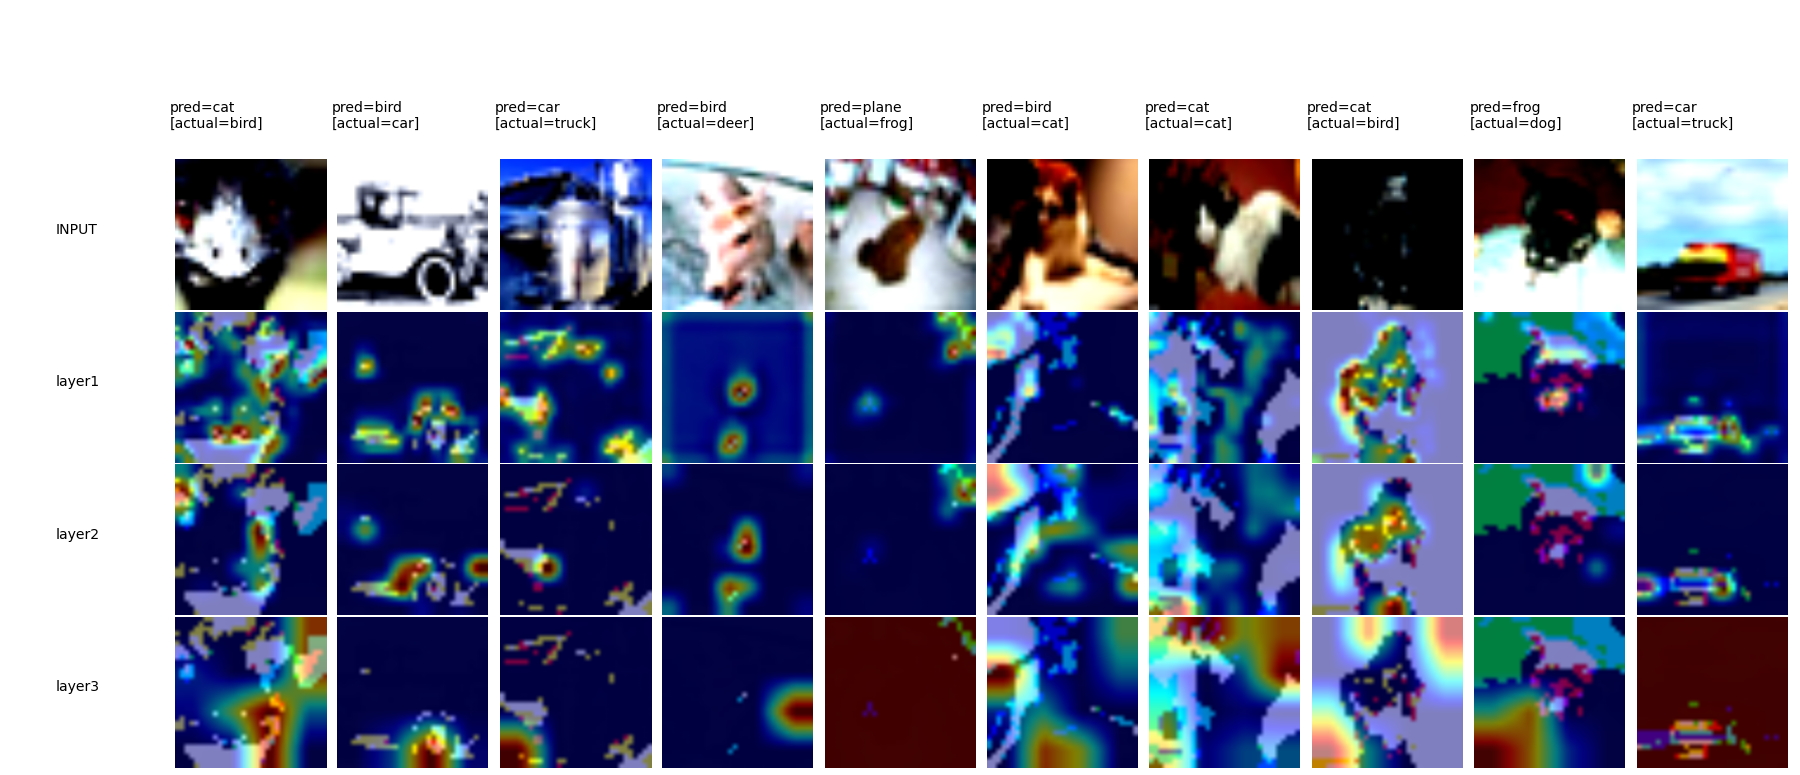

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

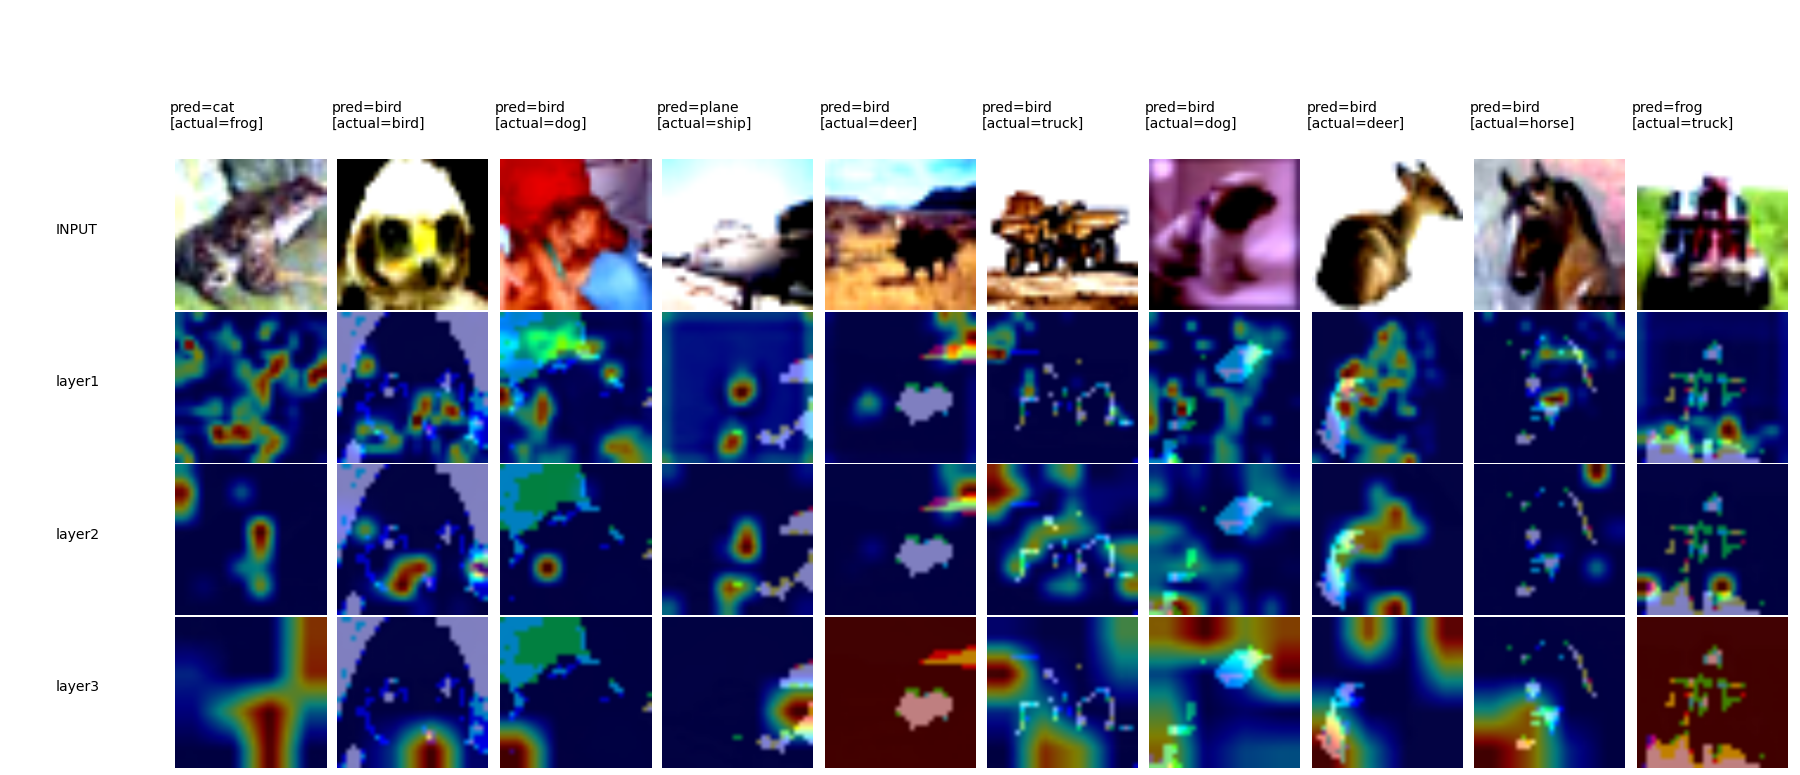

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


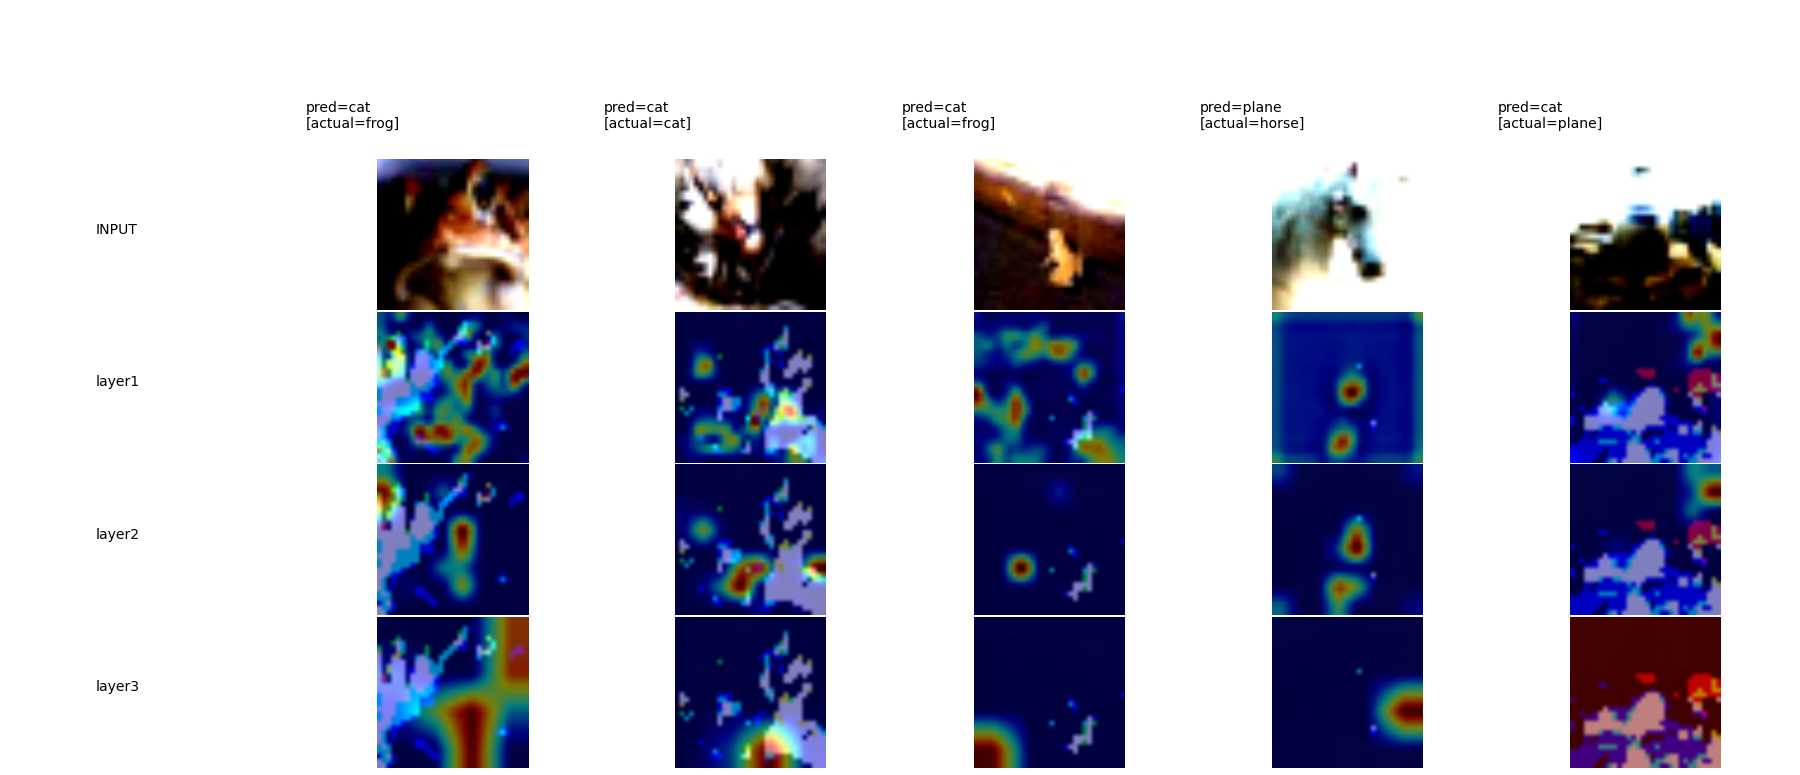

In [0]:
target_layers = ["layer1", "layer2", "layer3"]
gradcam_output, probs, predicted_classes = GRADCAM(incorrect_images, correct_label_list[0:25], model, target_layers)
print(len(predicted_classes))
PLOTGRADCAM(gradcam_output, incorrect_images_list[0:25],incorrect_images ,correct_label_list[0:25], target_layers, classes, (3, 32, 32), predicted_classes)
